In [1]:
from xpeem_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from scipy.interpolate import CubicSpline


This notebook demonstrates how cosine similarity is used for image analysis and how cosine similarity and linear combination were equated

Text(0, 0.5, 'Intensity (arb. u.)')

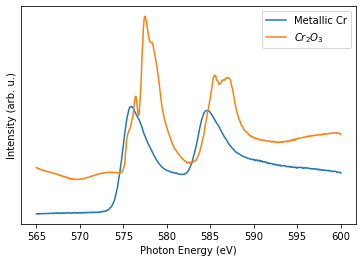

In [2]:
#Get the reference spectra
reference_spectra = pd.read_csv("Data/metal_oxide_XAS_ref.csv")
reference_spectra.head()
plt.plot(reference_spectra['Cr ref E'],reference_spectra['Cr ref'])
plt.plot(reference_spectra["Cr2o3 ref E"],reference_spectra['Cr2o3 ref'])

#Visualize the metal and oxide reference spectra
plt.legend(("Metallic Cr","$Cr_{2}O_{3}$"))
plt.yticks([])
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb. u.)")

In [3]:
#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
metal_ref_interp = CubicSpline(reference_spectra['Cr ref E'],reference_spectra['Cr ref'])
oxide_ref_interp = CubicSpline(reference_spectra["Cr2o3 ref E"],reference_spectra['Cr2o3 ref'])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
xrange = np.arange(570,584.2,0.2)
metal_ref = normalize_array(metal_ref_interp(xrange))
oxide_ref = normalize_array(oxide_ref_interp(xrange))

This section detials how the cosine similarity was equated to reference spectra by creating a series of linear combinations, calculating the normalized cosine similarity for each, then fitting a function based on that correlation

(101,)


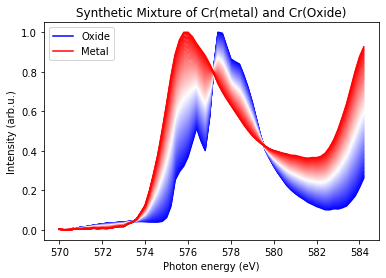

In [4]:
#Make a series of 100 linear combinations of metal and oxie reference spectra
percentrange = np.arange(0,1.01,.01)
print(percentrange.shape)
synth = np.tile(percentrange,(len(metal_ref),1)).T
synth_metal = np.tile(metal_ref,(len(percentrange),1))*synth
synth_oxide = np.tile(oxide_ref,(len(percentrange),1))*(1-synth)
synth_spectra = synth_metal+synth_oxide

#plot all the synthetic spectra
rb = plt.cm.get_cmap("bwr")
for i,row in enumerate(synth_spectra):
    if i == 0:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Oxide')
    elif i == len(synth_spectra)-1:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Metal')
    else:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='_nolegend_')
plt.ylabel('Intensity (arb.u.)')
plt.xlabel('Photon energy (eV)')
plt.title('Synthetic Mixture of Cr(metal) and Cr(Oxide)')
plt.legend()


0.44366806720214425 0.5563319327978555


Text(0.5, 1.0, 'Cosine Similarity of known synthetic spectra')

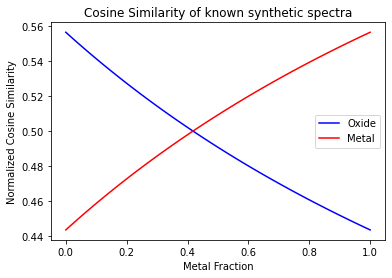

In [5]:
#calculate normalized cosine similarities for each synthetic mixture
oxide_cs_synth = np.zeros(percentrange.shape)
oxide_cs_list = np.zeros(percentrange.shape)
metal_cs_list = np.zeros(percentrange.shape)
for i, row in enumerate(synth_spectra):
    metal_cs = cosine_similarity_2d(row,metal_ref)
    oxide_cs = cosine_similarity_2d(row,oxide_ref)
    oxide_cs_synth[i] = oxide_cs/(metal_cs+oxide_cs)
    oxide_cs_list[i] = oxide_cs
    metal_cs_list[i] = metal_cs
params = np.polyfit(oxide_cs_synth,1-percentrange,2)
oxide_cs_to_percent_polyfit = np.poly1d(params)

#Visualize the normalized cosine similarity vs known fraction in the synthetic spectra
print(min(oxide_cs_synth),max(oxide_cs_synth))
plt.plot(percentrange,oxide_cs_synth, c='b')
plt.plot(percentrange,1-oxide_cs_synth,c='r')
plt.legend(["Oxide","Metal"])
plt.ylabel("Normalized Cosine Similarity")
plt.xlabel("Metal Fraction")
plt.title("Cosine Similarity of known synthetic spectra")

This section demonstrates how cosine similarity was calculated for the Cr hyperspectral image

In [19]:
#Read the 65L Cr XAS hyperspectral image, and only  use the L3 edge
cr_65L = imread("Data/65L Cr XAS 570-595 step0p2 masked.tif")[:72,:,:]

/Users/apple/vscode/Research/Ni22Cr XPEEM work/xpeem_utils.py:280: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))


Text(0.5, 1.0, 'b)')

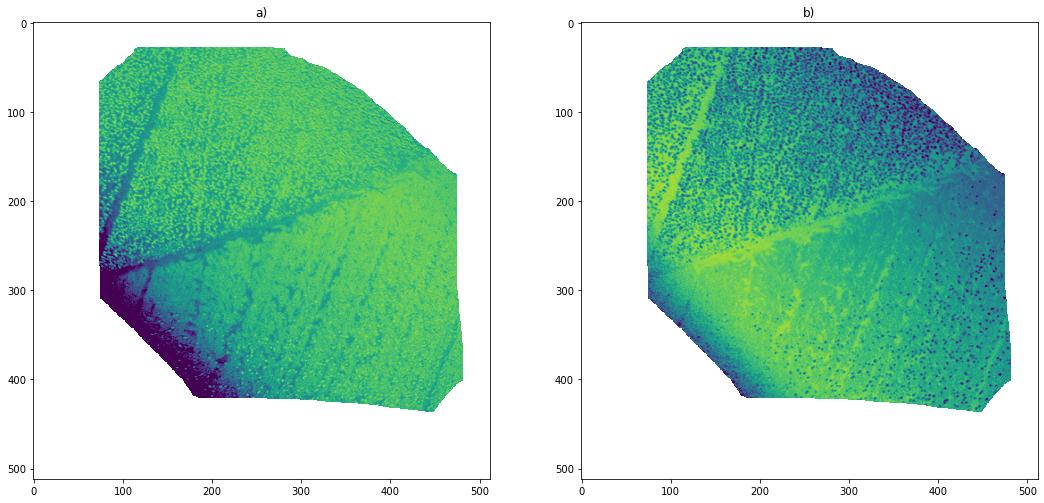

In [20]:
#Display the raw cosine similarity for a) oxide and b) metal
fig, axs = plt.subplots(ncols=2,figsize=(18,10))
axs[0].imshow(cosine_similarity_3d(cr_65L,oxide_ref),vmin=.8,vmax=1)
axs[1].imshow(cosine_similarity_3d(cr_65L,metal_ref),vmin=.8,vmax=1)
axs[0].set_title("a)")
axs[1].set_title("b)")


Text(0.5, 1.0, 'b)')

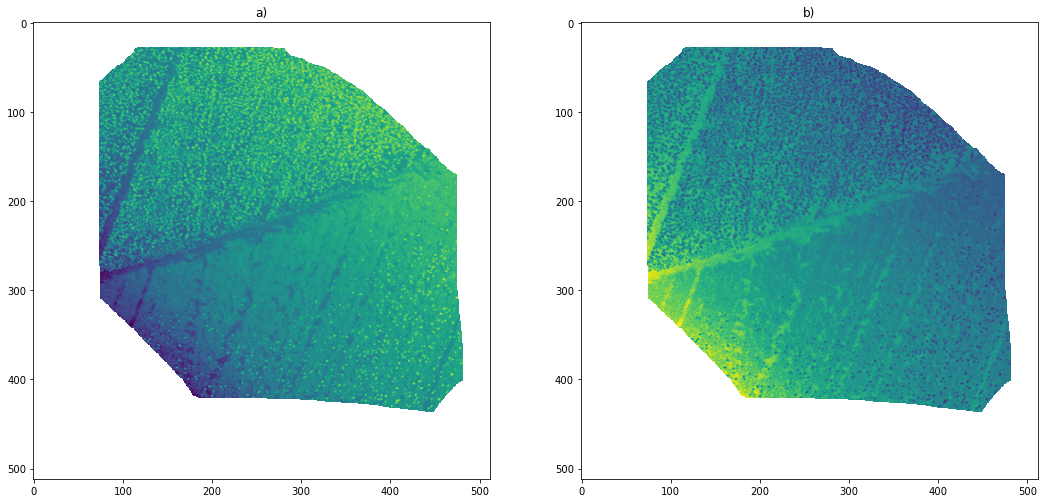

In [21]:
#Display the normalized cosine similarity for a) oxide and b) metal 
fig, axs = plt.subplots(ncols=2,figsize=(18,10))
axs[0].imshow(normed_cs_metal_ox(cr_65L,metal_ref,oxide_ref),vmin=.44,vmax=.56)
axs[1].imshow(normed_cs_metal_ox(cr_65L,oxide_ref,metal_ref),vmin=.44,vmax=.56)
axs[0].set_title("a)")
axs[1].set_title("b)")
